In [1]:
import pandas as pd
import random
import itertools
import datetime as dt
import matplotlib.pyplot as plt
import calendar
import numpy as np
import seaborn as sns

Downloaded data from: http://web.mta.info/developers/turnstile.html

Documentations at: http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt

Map of the MTA system: http://web.mta.info/maps/submap.html

In [2]:
df = pd.read_csv('clean_turnstile_data.csv')

/Users/kendra/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df['DATETIME'] = pd.to_datetime(df['DATETIME'], format='%Y-%m-%d %H:%M:%S')
df['DATE'] = pd.to_datetime(df['DATE'])

In [4]:
df.set_index('DATETIME', inplace=True)

In [5]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

Resample dataframe every 4 hours:

In [7]:
df2 = df.groupby(['STATION']).resample(rule='4H').sum().reset_index()

In [8]:
df2.drop(['ENTRIES','EXITS'], axis=1, inplace=True)

Add Day Of Week of column

In [9]:
df2['DAY_OF_WEEK'] = df2['DATETIME'].dt.weekday

In [11]:
df3 = df2.copy()

In [12]:
df3['DATE'] = pd.to_datetime(df3['DATETIME'].dt.date)
df3['TIME'] = df3['DATETIME'].dt.time

In [13]:
df3['TOTAL'] = df3['ENTRY_DIFFS'] + df3['EXIT_DIFFS']

In [14]:
df3.head()

,STATION,DATETIME,ENTRY_DIFFS,EXIT_DIFFS,DAY_OF_WEEK,DATE,TIME,TOTAL
0,1 AV,2018-05-19 00:00:00,1687.0,1107.0,5,2018-05-19,00:00:00,2794.0
1,1 AV,2018-05-19 04:00:00,673.0,1041.0,5,2018-05-19,04:00:00,1714.0
2,1 AV,2018-05-19 08:00:00,2864.0,3578.0,5,2018-05-19,08:00:00,6442.0
3,1 AV,2018-05-19 12:00:00,4839.0,5416.0,5,2018-05-19,12:00:00,10255.0
4,1 AV,2018-05-19 16:00:00,4982.0,6319.0,5,2018-05-19,16:00:00,11301.0


In [305]:
df3.to_csv('resampled_turnstile_data.csv')

## ANALYZE DATA

### Volume by 4-hr time slice

What stations experience the top volume in a 4-hr period?

In [42]:
df3.sort_values('TOTAL', ascending=False).head()

,STATION,DATETIME,ENTRY_DIFFS,EXIT_DIFFS,DAY_OF_WEEK,DATE,TIME,TOTAL
38508,GRD CNTRL-42 ST,2018-06-12 16:00:00,68663.0,36286.0,1,2018-06-12,16:00:00,104949.0
38514,GRD CNTRL-42 ST,2018-06-13 16:00:00,68066.0,35682.0,2,2018-06-13,16:00:00,103748.0
38520,GRD CNTRL-42 ST,2018-06-14 16:00:00,65734.0,36537.0,3,2018-06-14,16:00:00,102271.0
38430,GRD CNTRL-42 ST,2018-05-30 16:00:00,65756.0,36201.0,2,2018-05-30,16:00:00,101957.0
38388,GRD CNTRL-42 ST,2018-05-23 16:00:00,64473.0,35456.0,2,2018-05-23,16:00:00,99929.0


In [20]:
top_vol_4hr = list(set(df3.sort_values('TOTAL', ascending=False).head(400)['STATION']))

Histogram of 4-hr volumes? (Magnitude of # of people they can reach)

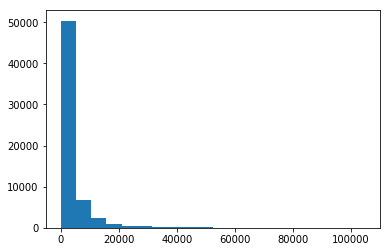

In [41]:
plt.hist(df3['TOTAL'], bins=20);

### Sum over all data

to get a list of high-volume stations

In [53]:
grp2 = df3.groupby(['STATION'])['ENTRY_DIFFS','EXIT_DIFFS', 'TOTAL'].sum().reset_index()

** KFnote: clean this up

In [51]:
grp3.head()

,STATION,DATE,ENTRY_DIFFS,EXIT_DIFFS
0,1 AV,2018-05-19,19241.0,21979.0
1,1 AV,2018-05-20,15258.0,16773.0
2,1 AV,2018-05-21,21686.0,23663.0
3,1 AV,2018-05-22,22712.0,25362.0
4,1 AV,2018-05-23,23654.0,25091.0


In [54]:
exit_high = list(grp2.sort_values('EXIT_DIFFS').tail(15)['STATION'])
entry_high = list(grp2.sort_values('ENTRY_DIFFS').tail(15)['STATION'])
highest_vol = list(set(exit_high + entry_high)) # this is a change!

In [55]:
top_vol_4hr.sort() == highest_vol.sort()

True

### Sum by Date

To make sure there are no anomalies on a certain day

In [56]:
grp3 = df3.groupby(['STATION','DATE'])['ENTRY_DIFFS','EXIT_DIFFS','TOTAL'].sum().reset_index()

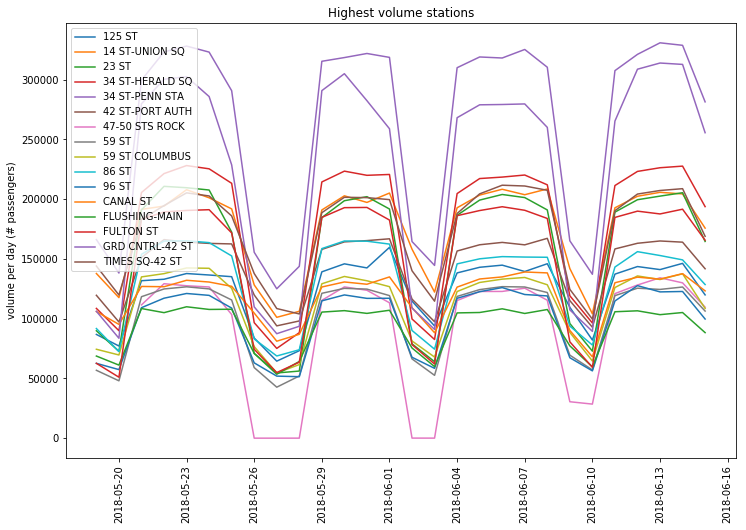

In [59]:
fig, ax = plt.subplots(figsize=[12,8])

for s in highest_vol:
    dum_df = grp3[grp3['STATION'] == s]
    xs = dum_df['DATE']
#     week_start = xs.iloc[0].strftime('%Y-%m-%d')
    plt.plot(xs, dum_df['TOTAL'], label=s)
#     xticklocs = ax.get_xticks()
#     plt.xticks(xticklocs, x_labels)
    plt.xticks(rotation=90)
    plt.legend()
    plt.ylabel('volume per day (# passengers)')
    plt.title('Highest volume stations');

### Average by Day of week

In [61]:
grp1 = df3.groupby(['STATION', 'DAY_OF_WEEK'])['ENTRY_DIFFS','EXIT_DIFFS','TOTAL'].mean().reset_index()

In [68]:
xlabels_dow = calendar.day_name[:]

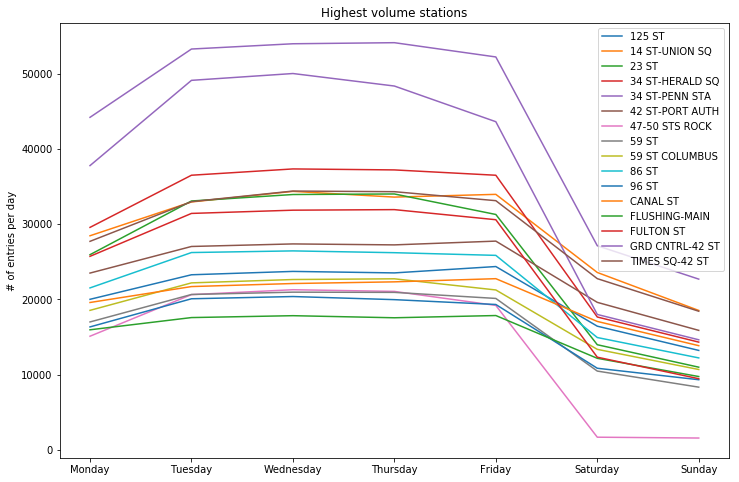

In [70]:
fig, ax = plt.subplots(figsize=[12,8])

for s in highest_vol:
    dum_df = grp1[grp1['STATION'] == s]
    xs = dum_df['DAY_OF_WEEK']
#     week_start = xs.iloc[0].strftime('%Y-%m-%d')
    plt.plot(xs, dum_df['TOTAL'], label=s)

# xticklocs = ax.get_xticks()
plt.xticks(np.arange(7), xlabels_dow)
# plt.xticks(rotation=90)
plt.legend()
plt.ylabel('# of entries per day')
plt.title('Highest volume stations');

### Heatmap: volume of traffic by day of week & time of day, for a given station

In [77]:
xlabel_hm = [str(int(x)) + 'h' for x in np.linspace(0,20,6)]
ylabel_hm = calendar.day_name[:]

In [261]:
def heatmap_data_by_day(s, data_col, year, month, day):
    '''Inputs:
        station key s 
        data_col (e.g. 'ENTRY_DIFFS')
        date: year, month, day
    Returns 
        Dataframe summed over that date, for that station, from that data_col'''
    d = dt.datetime(year, month, day)
    dum_df = df3[(df3['DATE'] == d) & (df3['STATION'] == s)]
    return dum_df.groupby('DATETIME')[data_col].sum()

In [74]:
def heatmap_data_by_dow(s, data_col, dow):
    '''Inputs:
        station key s 
        data_col (e.g. 'ENTRY_DIFFS')
        dow (day of weeks, an integer from 0-6, with 0 being Monday)
    Returns: 
        Dataframe summed over that day of week, grouped by time, for that station, from that data_col'''
    dum_df = df3[(df3['DAY_OF_WEEK'] == dow) & (df3['STATION'] == s)]
    return dum_df.groupby('TIME')[data_col].sum()

Use total. Make a heatmap for each station in highest_vol list.

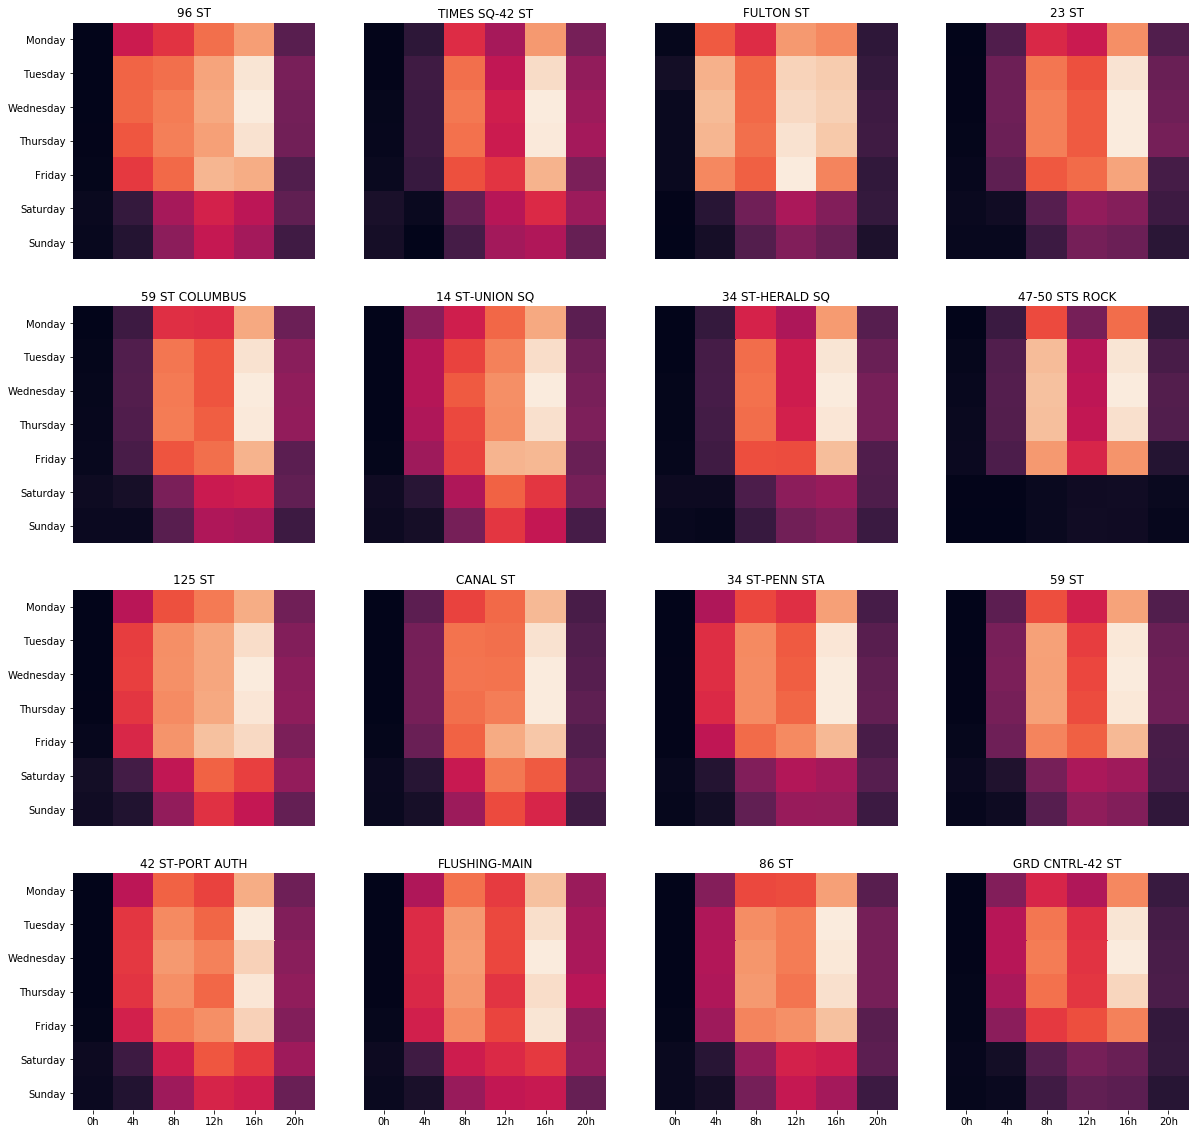

In [369]:
fig, ax = plt.subplots(4,4, figsize=(20,20))

for i, s in enumerate(highest_vol):
    plt.subplot(4,4,i+1)
    
    if i % 4 == 0:
        ylabel=yticks
    else:
        ylabel=False
    
    if i > 11:
        xlabel=xticks
    else:
        xlabel=False
    
    hm_data = [heatmap_data_by_dow(s, 'TOTAL', d) for d in range(7)]
    sns.heatmap(hm_data, xticklabels = xlabel_hm, yticklabels=ylabel_hm, cbar=False)
#     sns.heatmap(hm_data, cbar=False)
    plt.title(s)
    



In [81]:
lowest_vol = list(set(list(df3.sort_values('TOTAL').head(130)['STATION'])))
len(lowest_vol)

16

In [45]:
df3.index

RangeIndex(start=0, stop=62303, step=1)

In [ ]:
rand_vol = np.random.choice(df3.)

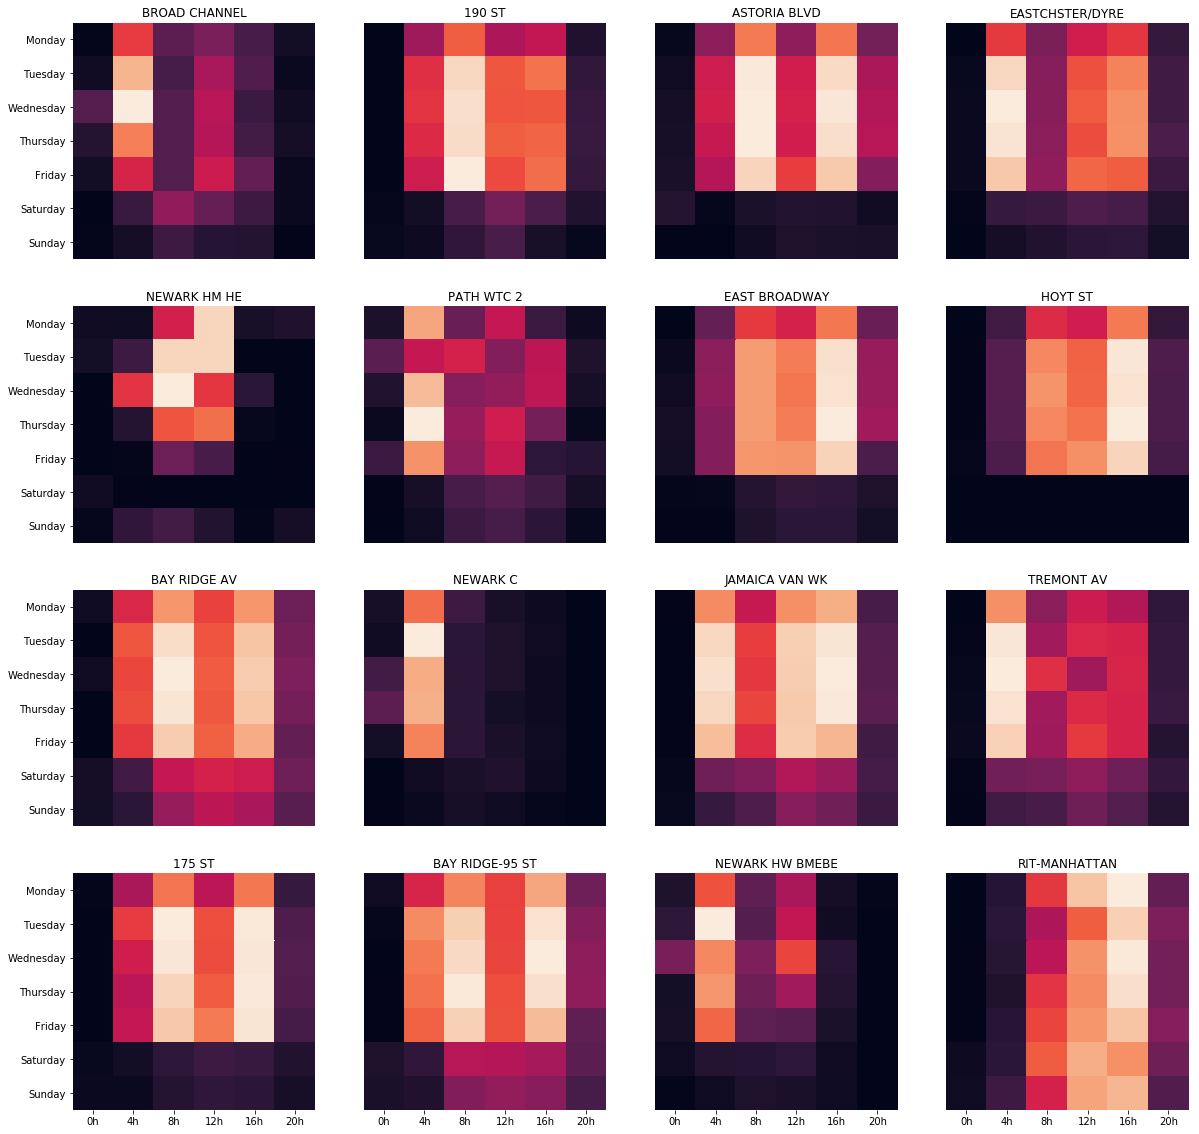

In [384]:
fig, ax = plt.subplots(4,4, figsize=(20,20))

for i, s in enumerate(lowest_vol):
    plt.subplot(4,4,i+1)
    
    if i % 4 == 0:
        ylabel=yticks
    else:
        ylabel=False
    
    if i > 11:
        xlabel=xticks
    else:
        xlabel=False
    
    hm_data = [heatmap_data_by_dow(s, 'TOTAL', d) for d in range(7)]
    sns.heatmap(hm_data, xticklabels = xlabel_hm, yticklabels=ylabel_hm, cbar=False)
#     sns.heatmap(hm_data, cbar=False)
    plt.title(s)
    

In [84]:
df3.head()

,STATION,DATETIME,ENTRY_DIFFS,EXIT_DIFFS,DAY_OF_WEEK,DATE,TIME,TOTAL
0,1 AV,2018-05-19 00:00:00,1687.0,1107.0,5,2018-05-19,00:00:00,2794.0
1,1 AV,2018-05-19 04:00:00,673.0,1041.0,5,2018-05-19,04:00:00,1714.0
2,1 AV,2018-05-19 08:00:00,2864.0,3578.0,5,2018-05-19,08:00:00,6442.0
3,1 AV,2018-05-19 12:00:00,4839.0,5416.0,5,2018-05-19,12:00:00,10255.0
4,1 AV,2018-05-19 16:00:00,4982.0,6319.0,5,2018-05-19,16:00:00,11301.0


In [89]:
vmax = df3['TOTAL'].max()
vmin = df3['TOTAL'].min()
vmax, vmin

(104949.0, 0.0)

Text(0.5,1,'Low volume')

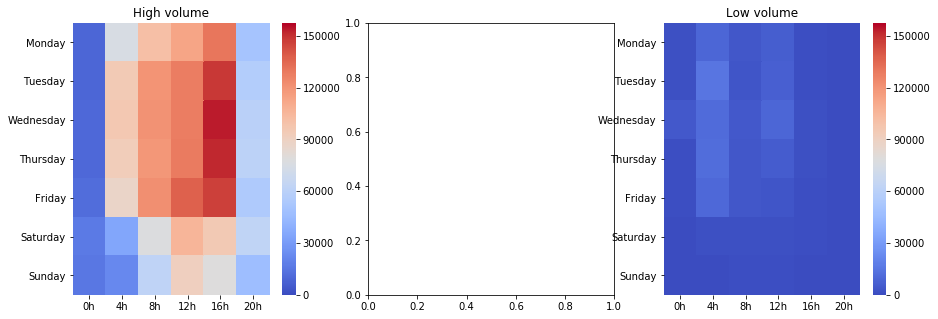

In [100]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

plt.subplot(1,3,1)
hm_data1 = [heatmap_data_by_dow(highest_vol[0], 'TOTAL', d) for d in range(7)]
sns.heatmap(hm_data1, xticklabels = xlabel_hm, yticklabels=ylabel_hm, cbar=True, vmax=vmax*1.5, vmin=0, cmap='coolwarm') 
hm_data = [heatmap_data_by_dow(s, 'TOTAL', d) for d in range(7)]
plt.title('High volume')

plt.subplot(1,3,3)
hm_data2 = [heatmap_data_by_dow(lowest_vol[0], 'TOTAL', d) for d in range(7)]
sns.heatmap(hm_data2, xticklabels = xlabel_hm, yticklabels=ylabel_hm, cbar=True, vmax=vmax*1.5, vmin=0, cmap='coolwarm')
hm_data = [heatmap_data_by_dow(s, 'TOTAL', d) for d in range(7)]
plt.title('Low volume')


    